# WDL Final - Improving the quality of life by reducing city noise levels

Team: AKITA

Background:

  Traffic, construction, and people, our lives in urban areas are filled with noise, which can be disturbing yet inevitable. Long-term exposure to excessive noise can cause serious health-related issues associated with hearing, mental state, and sleep quality. Our stress level, ability to concentrate, and other cognitive functions can therefore be affected. Cities around the globe have developed series of policies in order to minimize the impact of noise on humans while keep the city running at its pace, which is especially important for cities like Turin. Ergo the importance of correctly detecting and regulating noise is emphasized. 


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
pd.set_option('display.max_rows', 80)

## 1. Read Noise Sensor dataset

### 1.1 Inside San Salvario

We have 5 different sensor named from C1 to C5 inside San Salvario.

In [ ]:
# get the data from wdl
!wget https://wdl-data.fra1.digitaloceanspaces.com/torino/noise_data.zip
!unzip noise_data.zip

In [ ]:
# read all the files
noise_2021 = pd.read_csv('/content/noise_data/san_salvario_2021.csv', sep=';', skiprows=8)
noise_2020 = pd.read_csv('/content/noise_data/san_salvario_2020.csv', sep=';', skiprows=8)
noise_2019 = pd.read_csv('/content/noise_data/san_salvario_2019.csv', sep=';', skiprows=8)
noise_2018 = pd.read_csv('/content/noise_data/san_salvario_2018.csv', sep=';', skiprows=8)
noise_2017 = pd.read_csv('/content/noise_data/san_salvario_2017.csv', sep=';', skiprows=8)
noise_2016 = pd.read_csv('/content/noise_data/san_salvario_2016.csv', sep=';', skiprows=8)

# concate them togehter
noise_c = pd.concat([noise_2021, noise_2020, noise_2019, noise_2018, noise_2017, noise_2016], axis = 0)

# since the original db number use comma as decimal point change it
# replace comma with dot
noise_c['C1'] = noise_c['C1'].str.replace(',','.')
noise_c['C2'] = noise_c['C2'].str.replace(',','.')
noise_c['C3'] = noise_c['C3'].str.replace(',','.')
noise_c['C4'] = noise_c['C4'].str.replace(',','.')
noise_c['C5'] = noise_c['C5'].str.replace(',','.')
# change back to numeric
noise_c['C1'] = pd.to_numeric(noise_c['C1'])
noise_c['C2'] = pd.to_numeric(noise_c['C2'])
noise_c['C3'] = pd.to_numeric(noise_c['C3'])
noise_c['C4'] = pd.to_numeric(noise_c['C4'])
noise_c['C5'] = pd.to_numeric(noise_c['C5'])

We could that this is a dataset that contains the hourly noise at 5  locations in San Salvario.

In [ ]:
noise_c.head()

,Data,Ora,C1,C2,C3,C4,C5
0,01-01-2021,00:00,67.2,62.3,64.6,NaN,NaN
1,01-01-2021,01:00,48.9,44.4,47.8,NaN,NaN
2,01-01-2021,02:00,44.9,40.8,44.1,NaN,NaN
3,01-01-2021,03:00,42.0,39.2,41.7,NaN,NaN
4,01-01-2021,04:00,41.9,40.7,44.7,NaN,NaN


###  1.2. Outside San Salvario 

Merge with the TTO sensor data that outside the San Salvario due to an increasing busy nightlife.

In [ ]:
# read the tto sensor dataset
TTO1 = pd.read_csv('/content/noise_data/TTO-001_hourly.csv')
TTO2 = pd.read_csv('/content/noise_data/TTO-002_hourly.csv')

In [ ]:
# rename for merge
TTO1 = TTO1.rename(columns = {'mean': 'TTO1'})
TTO2 = TTO2.rename(columns = {'mean': 'TTO2'})

In [ ]:
import datetime
import pytz

In [ ]:
# since using UTC in the tto table, change to italian time 
# create timestamp based on time related column
TTO1['utc_time'] = pd.to_datetime(TTO1['date (UTC)'] + ' ' + TTO1['time (UTC)'])
TTO1['utc_time'] = pd.to_datetime(TTO1['utc_time'].dt.strftime('%d-%m-%Y %H:%M%S'))

TTO2['utc_time'] = pd.to_datetime(TTO2['date (UTC)'] + ' ' + TTO2['time (UTC)'])
TTO2['utc_time'] = pd.to_datetime(TTO2['utc_time'].dt.strftime('%d-%m-%Y %H:%M%S'))

# create both timezone objects
TTO1['italian_time'] = TTO1['utc_time'].dt.tz_localize('UTC').dt.tz_convert('Europe/Rome').dt.tz_localize(None)
TTO1[['date(italy)', 'Ora']] = TTO1['italian_time'].astype(str).str.split(' ', expand = True)

TTO2['italian_time'] = TTO2['utc_time'].dt.tz_localize('UTC').dt.tz_convert('Europe/Rome').dt.tz_localize(None)
TTO2[['date(italy)', 'Ora']] = TTO2['italian_time'].astype(str).str.split(' ', expand = True)

In [ ]:
# create datatime stamp for noise_c dataset to prepare for merge
noise_c['italian_time'] = pd.to_datetime(noise_c['Data'] + ' ' + noise_c['Ora'])
noise_c['italian_time'] = pd.to_datetime(noise_c['italian_time'].dt.strftime('%d-%m-%Y %H:%M%S'))

In [ ]:
# merge C type sensor dataset with TTO sensor dataset based on time
noise_full = pd.merge(noise_c, TTO1[['italian_time', 'TTO1']], how='outer', on =['italian_time'])
noise_full = pd.merge(noise_full, TTO2[['italian_time', 'TTO2']], how='outer', on =['italian_time'])

### 1.3 Plot 

Let's see how the noise changes for time to time for each sensor

Based on the cdc (Center of Disease Control and Prevention: https://www.cdc.gov/nceh/hearing_loss/what_noises_cause_hearing_loss.html), Noise above 70 dB over a prolonged period of time may start to damage your hearing.

#### 1.3.1 Overall Boxplot

In [ ]:
# let's plot to see the results of trend
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# sort the data by date
noise_full = noise_full.sort_values(by = ['italian_time'])

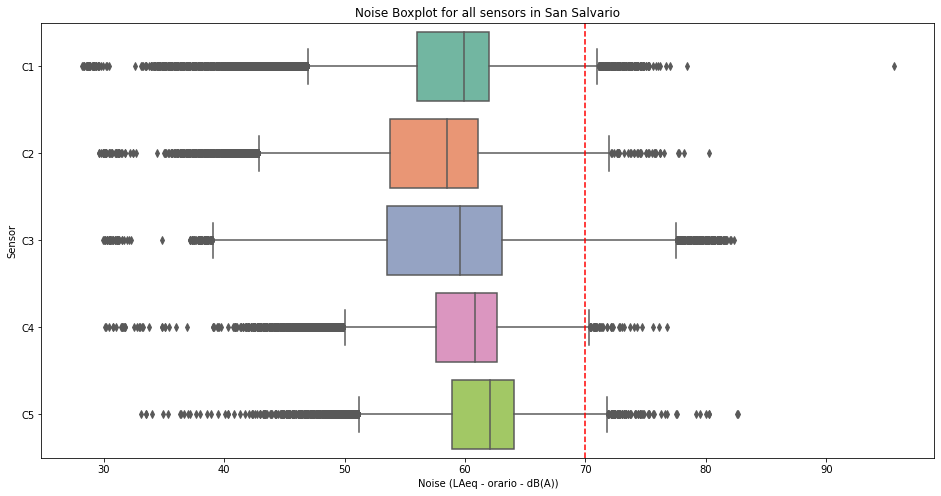

In [ ]:
fig, ax = plt.subplots(figsize = (16,8))
g = sns.boxplot(data=noise_full[['C1','C2','C3','C4','C5']].astype(np.double), orient="h", palette="Set2")
g.set(title = 'Noise Boxplot for all sensors in San Salvario', ylabel = 'Sensor', xlabel = 'Noise (LAeq - orario - dB(A))')
ax.axvline(70, ls = '--', color = 'r')

The boxplot shows a nonsignificant difference in the means, thus we ought to compare the ranges of the groups. Notice that while the majority of the data lies below the limit of 70dB, a small portion exceeded, especially for sensor C3, whose data attains a higher variability. 


#### 1.3.1 Noise vs Day of Week

In [ ]:
# get the weekday and month from time 
noise_full['weekday'] = noise_full['italian_time'].dt.strftime('%A')
noise_full['month'] = noise_full['italian_time'].dt.strftime('%m')

# calculate the average value of 5 sensor
noise_full['mean_c'] = noise_full[['C1', 'C2', 'C3','C4', 'C5']].mean(axis = 1)

Text(0.5, 1.0, 'Weekday vs Month: Max of 5 sensor noise from 2016-2021 in San Salvario')

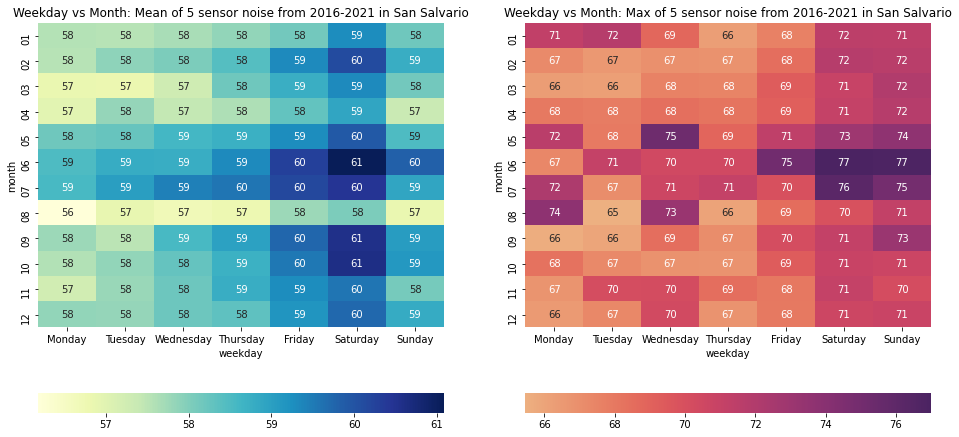

In [ ]:
# provide heatmap for mean noise value 
noise_weekday_month = pd.crosstab(noise_full['month'], noise_full['weekday'], values=noise_full['mean_c'],aggfunc=np.mean)
noise_weekday_month = noise_weekday_month[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]

# provide heat map for max noise value
noise_weekday_month_max = pd.crosstab(noise_full['month'], noise_full['weekday'], values=noise_full['mean_c'],aggfunc=np.max)
noise_weekday_month_max = noise_weekday_month_max[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]

# create canvas for two plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,8))

heat_month_weekday = sns.heatmap(noise_weekday_month, annot=True, cbar_kws= {'orientation':'horizontal'}, cmap="YlGnBu", ax = ax1)
heat_month_weekday.set_title('Weekday vs Month: Mean of 5 sensor noise from 2016-2021 in San Salvario')
heat_month_weekday_max = sns.heatmap(noise_weekday_month_max, annot=True, cbar_kws= {'orientation':'horizontal'}, cmap  ='flare', ax = ax2)
heat_month_weekday_max.set_title('Weekday vs Month: Max of 5 sensor noise from 2016-2021 in San Salvario')

Observe that the mean noise level on Fridays and Saturdays are higher than other days of a week, and the highest appears on Saturdays and Sundays. Higher overall noise level is also observed during early and mid-summer months. 

#### 1.3.2 Noise vs hour

In [ ]:
# get the hour from time 
noise_full['hour'] = noise_full['italian_time'].dt.strftime('%H')

Text(0.5, 1.0, 'Hour vs Weekday: Max of 5 sensor noise from 2016-2021 in San Salvario')

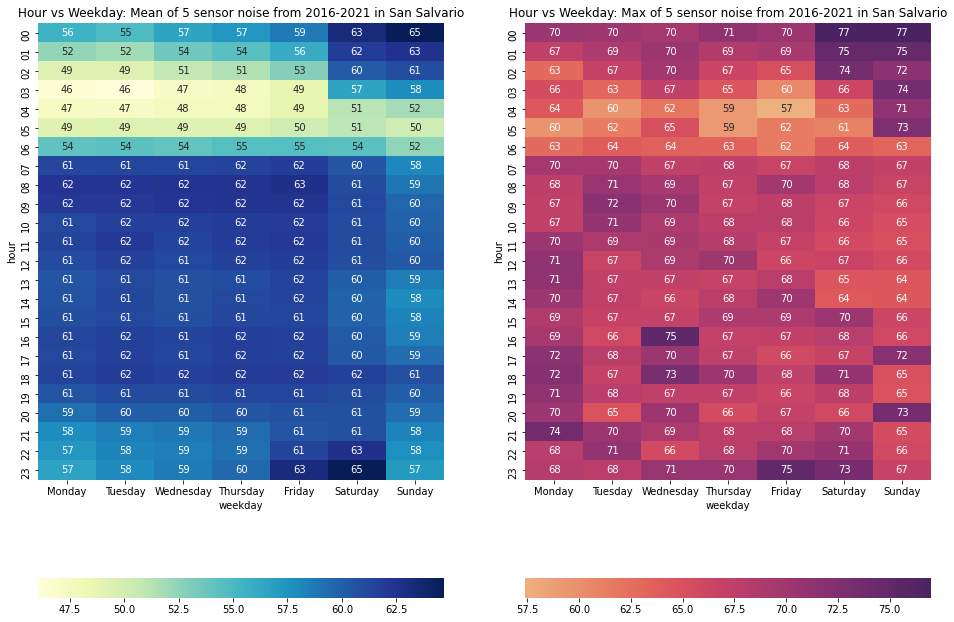

In [ ]:
# provide heatmap for mean noise value 
noise_weekday_month = pd.crosstab(noise_full['hour'], noise_full['weekday'], values=noise_full['mean_c'],aggfunc=np.mean)
noise_weekday_month = noise_weekday_month[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]

# provide heat map for max noise value
noise_weekday_month_max = pd.crosstab(noise_full['hour'], noise_full['weekday'], values=noise_full['mean_c'],aggfunc=np.max)
noise_weekday_month_max = noise_weekday_month_max[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]

# create canvas for two plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,12))

heat_month_weekday = sns.heatmap(noise_weekday_month, annot=True, cbar_kws= {'orientation':'horizontal'}, cmap="YlGnBu", ax = ax1)
heat_month_weekday.set_title('Hour vs Weekday: Mean of 5 sensor noise from 2016-2021 in San Salvario')
heat_month_weekday_max = sns.heatmap(noise_weekday_month_max, annot=True, cbar_kws= {'orientation':'horizontal'}, cmap  ='flare', ax = ax2)
heat_month_weekday_max.set_title('Hour vs Weekday: Max of 5 sensor noise from 2016-2021 in San Salvario')

During the hours in a day, higher noise level appears from 7am to midnight. This time range is extended during weekends. 

### 1.3 Sensor Locations

The location of first 5 sensors that are inside San Salvario is provided in a document. While the rest two are located at:
  + TTO-001: via Matteo Pescatore 17; LAT LONG: 45.06499, 7.69756
  + TTO-002: via Reggio 3; LAT LONG: 45.07452, 7.69446

In [ ]:
# read sensor location data
sensor_loc = pd.read_csv('https://wdl-data.fra1.digitaloceanspaces.com/torino/noise_sensor_list.csv', sep=';')
# format to numeric
sensor_loc['Lat'] = pd.to_numeric(sensor_loc['Lat'].str.replace(',','.'))
sensor_loc['Long'] = pd.to_numeric(sensor_loc['Long'].str.replace(',','.'))

# add TTO sensor location
sensor_loc.loc[5] = ['TTO-001', 'via Matteo Pescatore 17', 45.06499, 7.69756, np.nan]
sensor_loc.loc[6] = ['TTO-002', 'via Reggio 3',45.07452, 7.69446, np.nan]

In [ ]:
!pip install geopandas

In [ ]:
# transfer the geo location for prearation
import geopandas as gpd
gdf = gpd.GeoDataFrame(sensor_loc, geometry=gpd.points_from_xy(sensor_loc.Long, sensor_loc.Lat))

## 2. Business Nearby

In order to better understand the San Salvario Area, we include the location of Pub, restaurants, other business activities.

### 2.1 Business Level

The dataset contains three different information about the business: Type, description and merchandise type. Let's see whether they are valuable for us.

In [ ]:
# import the business dataframe for nearby business
business = pd.read_csv('https://wdl-data.fra1.digitaloceanspaces.com/torino/businesses.csv', sep = ';')

In [ ]:
business.head()

,WKT,ADDRESS,OPEN YEAR,OPEN MONTH,TYPE,Description,Merchandise Type,OPEN DAY,open_time
0,POINT (1396322.217 4990301.69),VIA CLAUDIO LUIGI BERTHOLLET 24,1977,1,EXTRALIMENTARI,PICCOLE STRUTTURE,Extralimentari,1,1977-01-01
1,POINT (1396322.217 4990301.69),VIA CLAUDIO LUIGI BERTHOLLET 24,1985,6,ALIMENTARI,PICCOLE STRUTTURE,Panificio,1,1985-06-01
2,POINT (1396303.762 4990325.001),VIA CLAUDIO LUIGI BERTHOLLET 25/F,2017,9,ALTRO,DIA di somministrazione,Nessuna,1,2017-09-01
3,POINT (1396434.395 4990540.6),CORSO VITTORIO EMANUELE II 21/A,2013,10,ALTRO,DIA di somministrazione,Nessuna,1,2013-10-01
4,POINT (1396434.395 4990540.6),CORSO VITTORIO EMANUELE II 21/A,2009,2,ALTRO,DIA di somministrazione,Nessuna,1,2009-02-01


In [ ]:
# define the date for business
# given the month and year only, assume they all open at the first day of month

import datetime
business['OPEN DAY'] = 1
business['open_time'] = pd.to_datetime((business['OPEN YEAR']*10000+business['OPEN MONTH']*100+business['OPEN DAY'])\
                                       .apply(str),format='%Y%m%d')

In [ ]:
# three piece of information given for each location, check how many levels for each columns
print('Unique Type:', business['TYPE'].nunique())
print('Unique Description:', business['Description'].nunique())
print('Unique Merchandise Type:', business['Merchandise Type'].nunique())

Unique Type: 5
Unique Description: 8
Unique Merchandise Type: 60


In [ ]:
# check what the levels are 
print('Unique Type:', business['TYPE'].unique())
print('Unique Description:', business['Description'].unique())

Unique Type: ['EXTRALIMENTARI' 'ALIMENTARI' 'ALTRO' '.' 'MISTA']
Unique Description: ['PICCOLE STRUTTURE' 'DIA di somministrazione' 'Somministrazione'
 'Acconciatori/estetisti' 'MEDIE STRUTTURE' 'FORME SPECIALI DI VENDITA'
 'Attivita didattiche' 'COSE ANTICHE E USATE']


Based on the result, we could sse that there exists 60 different merchandise type which is too much and too detail to analyze on. We would like to focus on the **Type** and **Description** of the business.

As for **Type**, there contains 5 different levels:

  + EXTRALIMENTARI - Extra Food
  + ALIMENTARI - Food
  + ALTRO - Other
  + . - Unknown
  + MISTA - Mixed

As for **Description**, there are 8 different levels:
  
  + PICCOLE STRUTTURE - small structure
  + DIA di somministrazione - start of business administration
  + Somministrazione - administration
  + Acconciatori/estetisti - Hairdressers/beauticians
  + MEDIE STRUTTURE - medium structure
  + FORME SPECIALI DI VENDITA - special form
  + Attivita didattiche - educational activities
  + COSE ANTICHE E USATE - ancient and used things

Since the **Description** contains more detailed information compared with **Type**, we would then focus on the Description of business.

### 2.2 Business Change Trend

Since the shop changes all the time at one location, we first would like to know how the business change at the area on the description level.

In [ ]:
# import needed library
from dateutil.relativedelta import *
from dateutil.rrule import *

In [ ]:
# since too many levels for Merchandise type, we decide the use description as the business attribute
# define function to count the business attribute at different month
def business_description_count(df, start_year, start_month, end_year, end_month):

  # define the start and end date (default the date is the second of the each month)
  startdate = datetime.datetime(start_year, start_month, 2)
  enddate = datetime.datetime(end_year, end_month, 2)

  # create the description level frame
  dep_count = pd.DataFrame({'Description': df.Description.unique()})

  # create the loop for record the date points
  while startdate <= enddate:

    # select the business location where open at the startdate
    row_select = df[df.open_time < startdate]
    # for the business with same address, select the row with largest date
    idx = row_select.groupby('ADDRESS')['open_time'].transform(max) == row_select['open_time']
    # count how open location for each category at the specfic time
    result = row_select[idx].groupby(['Description']).size().reset_index(name = startdate)
    # merge the result to description frame
    dep_count = pd.merge(dep_count, result, how = 'left', on = ['Description'])
    # increment the date by one month
    startdate = startdate + relativedelta(months=+1)
  
  # transpose the dataset
  dep_count = dep_count.T.reset_index()
  dep_count.columns = dep_count.iloc[0]
  dep_count = dep_count.iloc[1:]
  dep_count.index = range(dep_count.shape[0])

  # split the year and month
  dep_count['Description'] = dep_count['Description'].astype(str)
  dep_count['year'] = dep_count['Description'].str[0:4]
  dep_count['month'] = dep_count['Description'].str[5:7]

  return dep_count

We set the time range based on the noise records of the sensors.

In [ ]:
noise_full['italian_time'] = pd.to_datetime(noise_full['italian_time'])
print('The first date for noise record is', noise_full['italian_time'].min())
print('The last date for noise record is', noise_full['italian_time'].max())

The first date for noise record is 2016-06-01 00:00:00
The last date for noise record is 2021-06-24 08:00:00


In [ ]:
# based on the previous result define the first and end date for the function
description = business_description_count(business, 2016, 6,2021,6)
description['year_month'] = description['Description'].str[0:7]

In [ ]:
description.head()

,Description,PICCOLE STRUTTURE,DIA di somministrazione,Somministrazione,Acconciatori/estetisti,MEDIE STRUTTURE,FORME SPECIALI DI VENDITA,Attivita didattiche,COSE ANTICHE E USATE,year,month,year_month
0,2016-06-02 00:00:00,375,17,116,25,2,3,1,2,2016,06,2016-06
1,2016-07-02 00:00:00,379,17,117,26,2,3,1,2,2016,07,2016-07
2,2016-08-02 00:00:00,378,17,120,26,2,3,1,2,2016,08,2016-08
3,2016-09-02 00:00:00,377,18,124,24,2,3,1,2,2016,09,2016-09
4,2016-10-02 00:00:00,382,18,125,24,2,3,1,2,2016,10,2016-10


In [ ]:
# let's plot to see the results of trend
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib

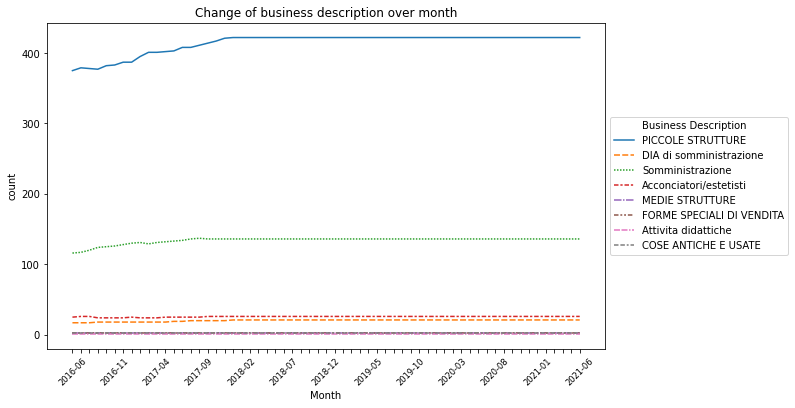

In [ ]:
# format the dataframe to plot
# pick only description type
description_plot = description.iloc[:,[1,2,3,4,5,6,7,8,11]]
description_plot.index = description_plot.year_month
description_plot = description_plot.drop(columns = ['year_month'])
# change to numeric
description_plot = description_plot.astype(float) 

# set the canvas
fig, ax = plt.subplots(figsize = (10,6))
# set what to plot
g = sns.lineplot(data = description_plot, ax = ax).set(title = 'Change of business description over month', xlabel = 'Month', ylabel = 'count')
# set legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 15})
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend.texts[0].set_text("Business Description")
# set label to rotate and show partial label for visual convenience
plt.xticks(np.arange(0,61,1), [description_plot.index[i] if i in range(0,61,5) else '' for i in range(61)])
plt.tick_params(axis = 'x', labelrotation=45, labelsize = 'small')

### 2.3 Plot the business density with around the sensor

In [ ]:
from shapely import wkt
business_pd = pd.read_csv('https://wdl-data.fra1.digitaloceanspaces.com/torino/businesses.csv', sep = ';')
business_pd.columns = ['geometry', 'ADDRESS', 'OPEN YEAR', 'OPEN MONTH', 'TYPE', 'Description','Merchandise Type']
business_pd['geometry'] = business_pd['geometry'].apply(wkt.loads)
business_pd = gpd.GeoDataFrame(business_pd, geometry = 'geometry')
business_pd.crs = 'epsg:3003'
business_pd = business_pd.to_crs(epsg = 4326)

In [ ]:
business_pd['location'] = business_pd['geometry'].astype(str)

In [ ]:
business_pd[['point','lat', 'long']] = business_pd['location'].str.split(' ',expand = True)
business_pd = business_pd.drop(columns = ['point'])
business_pd['lat'] = pd.to_numeric(business_pd['lat'].str[1:])
business_pd['long'] = pd.to_numeric(business_pd['long'].str[:-1])

In [ ]:
import folium
from folium.plugins import HeatMap

# Instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# Loop through the prediction and add each to the incidents feature group
for lat, long, in zip(sensor_loc.Lat, sensor_loc.Long):
    incidents.add_child(
        folium.CircleMarker(
            [lat, long],
            radius=7, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='black',
            fill_opacity=0.4
        )
    )

# Add incidents to map
latitude = 45.057837
longitude = 7.681555 
day_map = folium.Map(location=[latitude, longitude], zoom_start=16.5)
day_map.add_child(incidents)

# add heatmap layer
heatdata = business_pd[['long','lat']].drop_duplicates().values.tolist()
# add incidents to map
HeatMap(heatdata).add_to(day_map)

day_map

## 3. Merge with the weather data

In [ ]:
!wget https://wdl-data.fra1.digitaloceanspaces.com/torino/weather.zip
!unzip weather.zip

In [ ]:
def weather_clean(df):
  df=df.replace({',': '.'}, regex=True)
  df=df.fillna(0)
  df=df.astype(float,errors="ignore")
  df[['Hour','Minutes']] = df.Time.str.split(":",expand=True,)
  hourly=df.groupby(["Date","Hour"]).mean().reset_index()
  hourly.Hour=hourly.Hour+":00"
  return hourly

In [ ]:
rain  = pd.read_csv('/content/weather/weather_1.csv',sep=";",skiprows=4, nrows=266112)
del rain['Unnamed: 3']
rain.columns=["Date","Time","Rain level(Millimeters)"]
rain_hourly=weather_clean(rain)

In [ ]:
Snow_Temp  = pd.read_csv('/content/weather/weather_1.csv',sep=";",skiprows=266122)
Snow_Temp.columns=["Date","Time","Snow depth","Temperature"]
Snow_Temp_hourly=weather_clean(Snow_Temp)

In [ ]:
Wind_scalar  = pd.read_csv('/content/weather/weather_2.csv',sep=";",skiprows=4,nrows=266112)
Wind_scalar.columns=["Date","Time","Wind speed (scalar m/s) "]
Wind_scalar_hourly=weather_clean(Wind_scalar)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
Wind_gust  = pd.read_csv('/content/weather/weather_2.csv',sep=";",skiprows=266122)
Wind_gust.columns=["Date","Time","Wind speed (gust m/s) "]
Wind_gust_hourly=weather_clean(Wind_gust)

In [ ]:
# prepare the dataset for merge, create timestamp use data and hour
Wind_gust_hourly['italian_time'] = pd.to_datetime(Wind_gust_hourly['Date'] + ' ' + Wind_gust_hourly['Hour'])
Wind_gust_hourly['italian_time'] = pd.to_datetime(Wind_gust_hourly['italian_time'].dt.strftime('%d-%m-%Y %H:%M%S'))

Wind_scalar_hourly['italian_time'] = pd.to_datetime(Wind_scalar_hourly['Date'] + ' ' + Wind_scalar_hourly['Hour'])
Wind_scalar_hourly['italian_time'] = pd.to_datetime(Wind_scalar_hourly['italian_time'].dt.strftime('%d-%m-%Y %H:%M%S'))

Snow_Temp_hourly['italian_time'] = pd.to_datetime(Snow_Temp_hourly['Date'] + ' ' + Snow_Temp_hourly['Hour'])
Snow_Temp_hourly['italian_time'] = pd.to_datetime(Snow_Temp_hourly['italian_time'].dt.strftime('%d-%m-%Y %H:%M%S'))

rain_hourly['italian_time'] = pd.to_datetime(rain_hourly['Date'] + ' ' + rain_hourly['Hour'])
rain_hourly['italian_time'] = pd.to_datetime(rain_hourly['italian_time'].dt.strftime('%d-%m-%Y %H:%M%S'))

In [ ]:
# merge weather with noise based on time
noise_full = pd.merge(noise_full, Wind_gust_hourly[['italian_time', 'Wind speed (gust m/s) ']], how='outer', on =['italian_time'])
noise_full = pd.merge(noise_full, Wind_scalar_hourly[['italian_time', 'Wind speed (scalar m/s) ']], how='outer', on =['italian_time'])
noise_full = pd.merge(noise_full, Snow_Temp_hourly[['italian_time', 'Temperature', 'Snow depth']], how='outer', on =['italian_time'])
noise_full = pd.merge(noise_full, rain_hourly[['italian_time', 'Rain level(Millimeters)']], how='outer', on =['italian_time'])

In [ ]:
# extract the month and year for preparation
noise_full['year'] = noise_full['italian_time'].dt.strftime('%Y')
noise_full['month'] = noise_full['italian_time'].dt.strftime('%A')

##4. Noise prediction

### 4.1.Data preparation
+ Our data is related to time, so the processing method of time series is very appropriate.
+ At the same time we used all weather data as variables.
+ For example, we use the data of C1, C2, C3, C4, C5, TT01, TT02, weather of the previous time to predict the noise data of C1/C2/C3/C4/C5 at the current moment

In [ ]:
from keras.layers import *
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
!git clone https://github.com/niuniuwanku/WDL

Cloning into 'WDL'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 18 (delta 0), reused 2 (delta 0), pack-reused 15
Unpacking objects: 100% (18/18), done.
Checking out files: 100% (12/12), done.


In [ ]:
noise_prediction=pd.read_csv("/content/WDL/noise_predcition.csv",index_col=[0])
noise_prediction=noise_prediction.drop(["Data","Ora","italian_time","year","month"],axis=1)

In [ ]:
noise_prediction

,C1,C2,C3,C4,C5,TTO1,TTO2,Wind speed (gust m/s),Wind speed (scalar m/s),Temperature,Snow depth,Rain level(Millimeters)
0,61.1,58.8,63.7,60.4,61.1,NaN,NaN,NaN,0.583333,7.10,-0.010,0.0
1,57.2,56.1,60.4,57.7,57.2,NaN,NaN,1.4,0.266667,14.20,-0.035,0.0
2,52.5,53.4,52.9,56.7,52.5,NaN,NaN,1.4,0.066667,14.30,-0.015,0.0
3,50.6,46.6,45.7,47.9,50.6,NaN,NaN,0.8,0.033333,14.25,-0.035,0.0
4,47.4,46.2,45.1,45.8,47.4,NaN,NaN,1.2,0.083333,14.25,0.030,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
44384,NaN,NaN,NaN,NaN,NaN,NaN,60.2,NaN,NaN,NaN,NaN,NaN
44385,NaN,NaN,NaN,NaN,NaN,NaN,60.5,NaN,NaN,NaN,NaN,NaN
44386,NaN,NaN,NaN,NaN,NaN,NaN,60.8,NaN,NaN,NaN,NaN,NaN
44387,NaN,NaN,NaN,NaN,NaN,NaN,62.6,NaN,NaN,NaN,NaN,NaN


### 4.2.Model
+ With one Masking layer deal with missing value, two LSTM layers and four Dense layers.(Total params: 7,953,537)
+ sample training(C1 10 epochs)
+ attached full model for five sensor

In [ ]:
from random import random
from numpy import array
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [ ]:
def targety(target,data):
  df=data.copy()
  df = concat([df[target].shift(-1), df], axis=1)
  df.fillna(-1, inplace=True)
  X=df.iloc[:,1:].values
  y=df.iloc[:, 0].values
  return X,y

### 4.2.1 Train test split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(targety("C1",noise_prediction)[0],targety("C1",noise_prediction)[1], test_size = 0.2, random_state = 0)

### 4.2.2 Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train = X_train.reshape(len(X_train), 1,12)
y_train = y_train.reshape(len(y_train), 1)
X_test = X_test.reshape(len(X_test), 1,12)
y_test = y_test.reshape(len(y_test), 1)

### 4.2.3 Call back define

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
my_callbacks = [EarlyStopping(monitor='val_mean_squared_error',patience=20),
         ModelCheckpoint("best size C1.hdf5",monitor="val_mean_squared_error",verbose=1,save_best_only=True)]

### 4.2.4 Sequential neural network

In [ ]:
model = Sequential()
model.add(Masking(mask_value=-1., input_shape=(1,12)))
model.add(LSTM(1024,return_sequences=True))
model.add(LSTM(512,return_sequences=True))
model.add(TimeDistributed(Dense(units = 512, activation = 'relu')))
#model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(units = 256, activation = 'relu')))
model.add(TimeDistributed(Dense(units = 64, activation = 'relu')))
model.add(TimeDistributed(Dense(units = 1)))
model.compile(optimizer = 'sgd',loss = 'Huber',metrics=['mean_squared_error'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 1, 12)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 1024)           4247552   
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 512)            3147776   
_________________________________________________________________
time_distributed_8 (TimeDist (None, 1, 512)            262656    
_________________________________________________________________
time_distributed_9 (TimeDist (None, 1, 256)            131328    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 1, 64)             16448     
_________________________________________________________________
time_distributed_11 (TimeDis (None, 1, 1)             

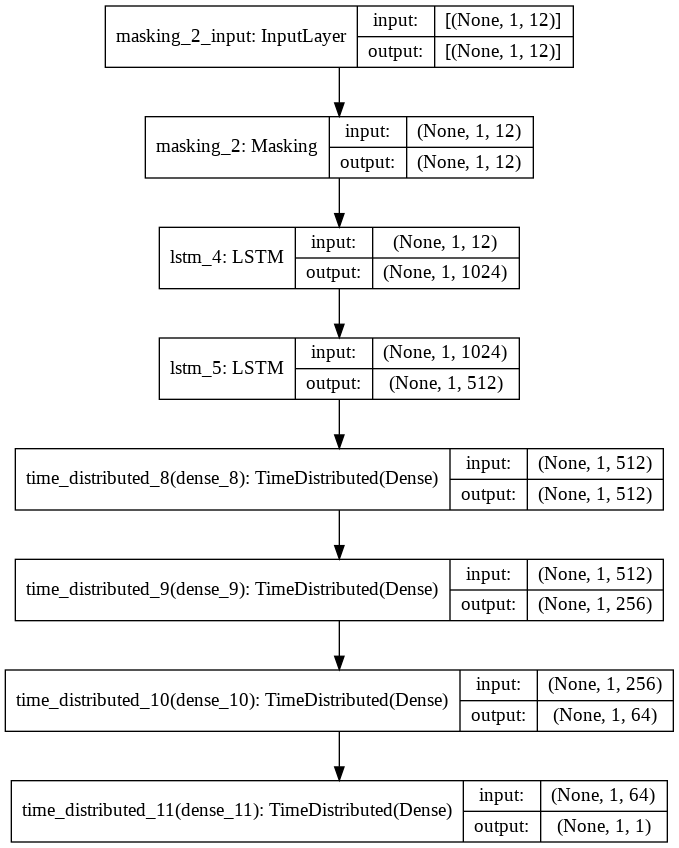

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)

### 4.2.5 Fit(train)


In [ ]:
history=model.fit(X_train, y_train,batch_size=128, epochs = 10,validation_data=(X_test, y_test),callbacks=[my_callbacks])

Epoch 1/10
278/278 [==============================] - 104s 273ms/step - loss: 39.0844 - mean_squared_error: 2154.6754 - val_loss: 7.8179 - val_mean_squared_error: 86.8190

Epoch 00001: mean_squared_error improved from inf to 1084.55615, saving model to best size C1.hdf5
Epoch 2/10
278/278 [==============================] - 72s 260ms/step - loss: 6.0012 - mean_squared_error: 63.8908 - val_loss: 7.5874 - val_mean_squared_error: 87.6428

Epoch 00002: mean_squared_error improved from 1084.55615 to 61.34922, saving model to best size C1.hdf5
Epoch 3/10
278/278 [==============================] - 72s 260ms/step - loss: 5.1694 - mean_squared_error: 54.8924 - val_loss: 6.6329 - val_mean_squared_error: 71.8210

Epoch 00003: mean_squared_error improved from 61.34922 to 52.31809, saving model to best size C1.hdf5
Epoch 4/10
278/278 [==============================] - 72s 259ms/step - loss: 4.6158 - mean_squared_error: 46.4063 - val_loss: 3.3410 - val_mean_squared_error: 31.2873

Epoch 00004: mean_s

### 4.3.Model evaluation
+ Based on our full trained model, the mse error is around 20
+ From the loss and mean_squared_error plot, we find out the model truely study from the data.

(-0.5, 431.5, 287.5, -0.5)

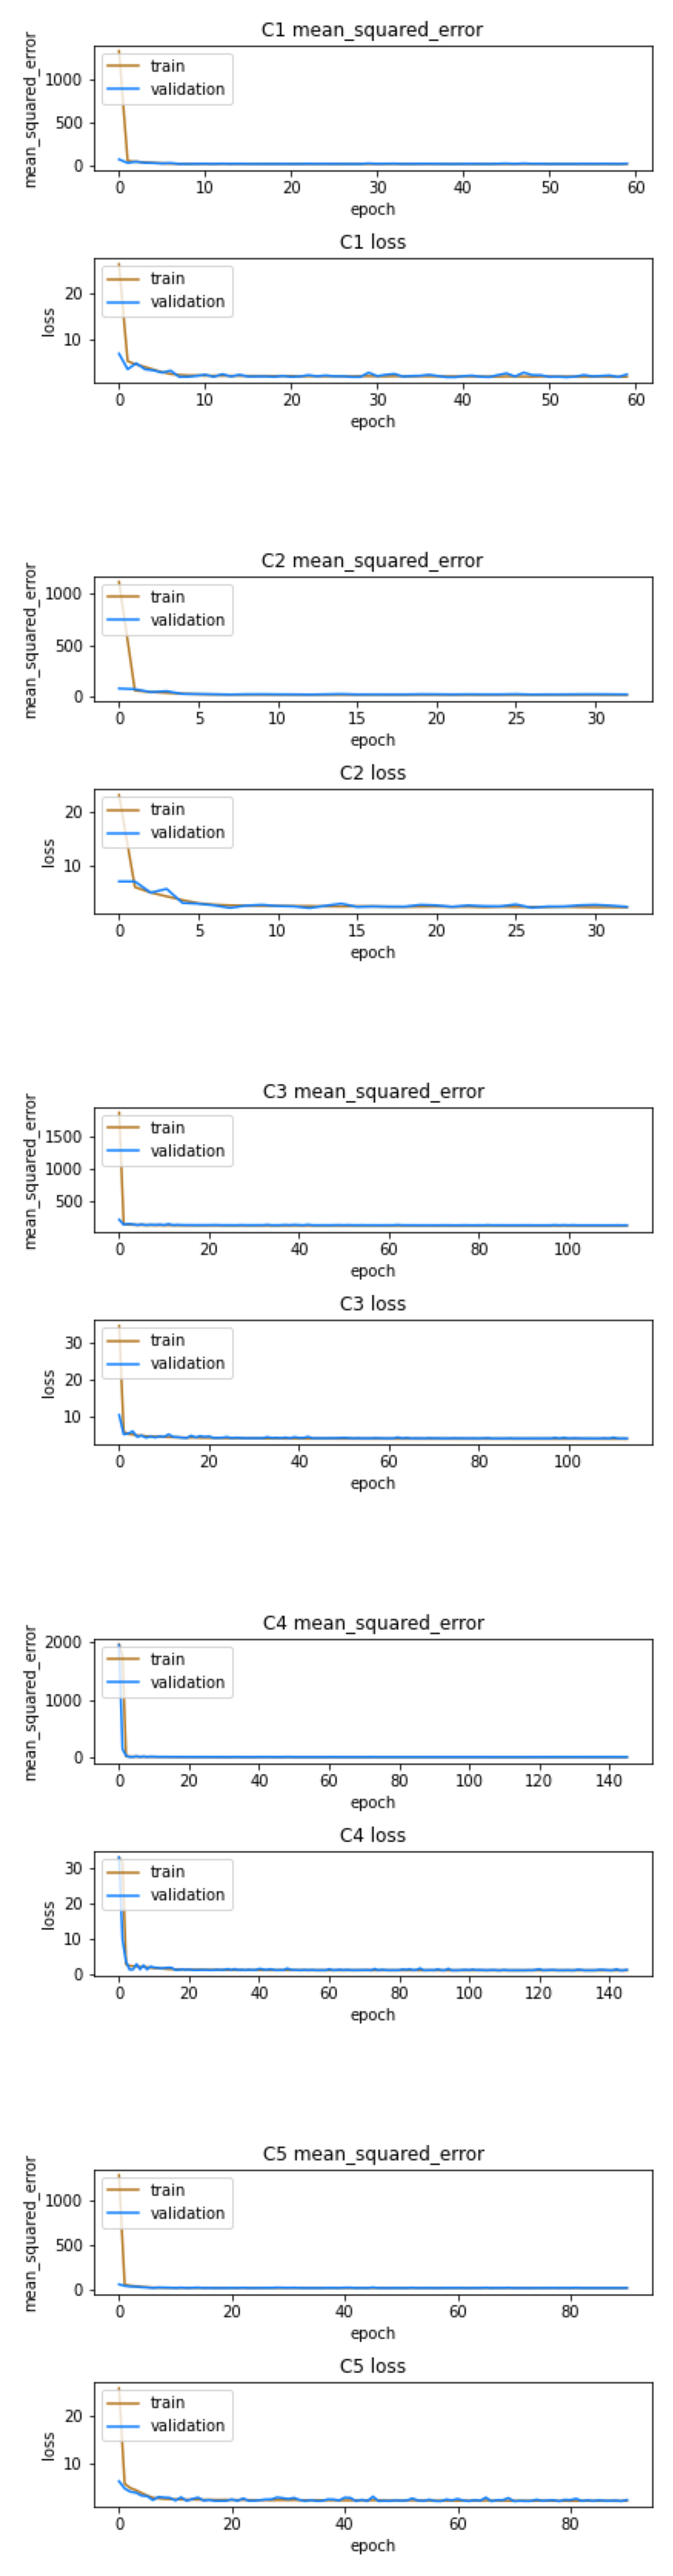

In [ ]:
import cv2
from matplotlib import pyplot as plt
Image1 = cv2.imread('/content/WDL/C1.png')
Image2 = cv2.imread('/content/WDL/C2.png')
Image3 = cv2.imread('/content/WDL/C3.png')
Image4 = cv2.imread('/content/WDL/C4.png')
Image5 = cv2.imread('/content/WDL/C5.png')
fig = plt.figure(figsize=(100, 70))
plt.subplot(5, 1, 1)
plt.imshow(Image1)
plt.axis('off')
plt.subplot(5, 1, 2)
plt.imshow(Image2)
plt.axis('off')
plt.subplot(5, 1, 3)
plt.imshow(Image3)
plt.axis('off')
plt.subplot(5, 1, 4)
plt.imshow(Image4)
plt.axis('off')
plt.subplot(5, 1, 5)
plt.imshow(Image5)
plt.axis('off')

### 4.4.Model useage
+ In the future, we could use new or time-sensitive to feed the model and get more accuracy.
+ We can predict the next time-step noise value base on the pervious data.

In [ ]:
from keras.models import load_model
model = load_model('/content/WDL/best size C1.hdf5')

In [ ]:
model.predict(X_test)

array([[[61.623814]],

       [[62.322666]],

       [[61.96853 ]],

       ...,

       [[61.901863]],

       [[63.500767]],

       [[58.953323]]], dtype=float32)

## 5. Complaints

### 5.1. Filter the complaints in San Salvario

Since the complaints dataframe provides on the district of complaints and San Salvario is part of district 8. Our steps here are:

+ Select complaints only distrcit 8
+ Get latitude and longitude from street name
+ Compare the compliants lat and long with San Salvario, decide whether inside

#### 5.1.1 Select complaints only in distrcit 8

In [ ]:
!pip install geopandas

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd

In [ ]:
!wget https://wdl-data.fra1.digitaloceanspaces.com/torino/police_complaints.zip
!unzip police_complaints.zip

In [ ]:
# read all the complaints file
complaints_0 = pd.read_csv('/content/police_complaints/Contact_Luglio_Dicembre_2016.csv', encoding= 'ISO-8859-1')
complaints_1 = pd.read_csv('/content/police_complaints/OpenDataContact_Gennaio_Giugno_2016.csv', encoding = "ISO-8859-1")
complaints_2 = pd.read_excel('/content/police_complaints/OpenDataContact_Gennaio_Giugno_2018.xlsx')
complaints_3 = pd.read_csv('/content/police_complaints/OpenDataContact_Gennaio_Giugno_2019.csv', encoding = "ISO-8859-1")
complaints_4 = pd.read_csv('/content/police_complaints/OpenDataContact_Luglio_Dicembre_2017.csv', encoding = "ISO-8859-1")
complaints_5 = pd.read_csv('/content/police_complaints/OpenDataContact_Luglio_Dicembre_2018.csv', encoding = "ISO-8859-1")
complaints_6 = pd.read_csv('/content/police_complaints/OpenDataContact_Luglio_Dicembre_2019.csv', encoding = "ISO-8859-1", sep = ';')
complaints_7 = pd.read_csv('/content/police_complaints/Contact_Gennaio_Giugno_2017.csv', encoding= 'ISO-8859-1')

# concate the data together
complaints = pd.concat([complaints_0, complaints_1, complaints_2,complaints_3
                       ,complaints_4,complaints_5,complaints_6,complaints_7]
                       , axis = 0)

#### 5.1.2 Get latitude and longitude from street name

From the previous steps, there are 755 compliants in the year 2016 to 2019 in ditrict 8. We need to get the latitude and longitude to further on narrow the complaints in San Salvario.

In [ ]:
# since san salvario is in district 8, include only district 8 data
complaints_8 = complaints.loc[(complaints['Circoscrizione'] == 8)]

In [ ]:
complaints_8.head()

,Categoria criminologa,Sottocategoria Criminologica,Circoscrizione,Localita,Area Verde,Data,Ora
1,Allarme Sociale,Altro,8.0,ORMEA/(VIA) ...,NaN,12/07/2016,NaN
2,Allarme Sociale,Altro,8.0,ORMEA/(VIA) ...,NaN,12/07/2016,NaN
4,Allarme Sociale,Altro,8.0,ORMEA/(VIA) ...,NaN,18/07/2016,NaN
8,Allarme Sociale,Altro,8.0,ORMEA/(VIA) ...,Area Verde,26/07/2016,NaN
19,Allarme Sociale,Altro,8.0,BERTHOLLET/CLAUDIO LUIGI (VIA) ...,NaN,09/09/2016,NaN


In [ ]:
# since the data does not contains lat and long 
# get lat and long based on it location information

import requests
import urllib.parse
lat, long = [],[]

for i in range(complaints_8.shape[0]):
  address = complaints_8.iloc[i,3]
  url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'

  response = requests.get(url).json()

  # in case that we didi not rest the lat and long and break the loop, impute missing
  if response == []:
    lat.append(np.nan)
    long.append(np.nan)
  else:
    lat.append(response[0]["lat"])
    long.append(response[0]["lon"])

In [ ]:
# merge the lat and long information back to the dataset
complaints_8['lat'] = lat
complaints_8['long'] = long

In [ ]:
# there are still 125 rows that missing ,use another way to check the lat and long
complaints_8_miss = complaints_8[complaints_8.lat.isna()]
complaints_8_miss.shape

(125, 9)

We could see that through the previous way, we could only get most of the complaints location. Try another way to ammend for the rest.

In [ ]:
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim


# 1 - conveneint function to delay between geocoding calls
locator = Nominatim(user_agent='myGeocoder')
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2- - create location column
complaints_8_miss['location'] = complaints_8_miss['Localita'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
complaints_8_miss['point'] = complaints_8_miss['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
complaints_8_miss[['latitude', 'longitude', 'altitude']] = pd.DataFrame(complaints_8_miss['point'].tolist(), index=complaints_8_miss.index)

In [ ]:
complaints_8_miss[complaints_8_miss.latitude.isna()]

,Categoria criminologa,Sottocategoria Criminologica,Circoscrizione,Localita,Area Verde,Data,Ora,lat,long,location,point,latitude,longitude,altitude
367,Convivenza Civile,Disturbi Cani,8.0,FIGLIE DEI MILITARI/(VIA),NaN,11/07/2017,12.02,NaN,NaN,None,None,NaN,NaN,NaN
448,Convivenza Civile,Comportamenti molesti,8.0,PONTE ISABELLA A S. VITO/(STRADA DEL),NaN,03/04/2017,NaN,NaN,NaN,None,None,NaN,NaN,NaN
825,Qualitï¿½ Urbana,Altro,8.0,FIGLIE DEI MILITARI/(VIA),NaN,17/05/2017,NaN,NaN,NaN,None,None,NaN,NaN,NaN


Through these two ways , we still cannot get the lat and long for 3 cases. Based on the dataframe that contains all the street names in San Salvario (https://github.com/rainieluo2016/WDL/blob/main/san_salvarito_street.csv) which is a dataframe I have sorted according (http://www.quartieri.torino.it/sansalvario/elencovie.asp), this street is not in the list. Therefore, we could just directly delete it from the dataframe.

The reason that we do not directly use this dataframe to filter the district 8 compliants in San Salario is that the streets' name are not written in the same format in both cases, such as abbreviation. Therefore, filtering through Latitude and Longitude is more accurate.

In [ ]:
# format the dataframe as the original
complaints_8_miss = complaints_8_miss.drop(columns = ['lat', 'long', 'altitude', 'location', 'point'])
complaints_8_miss = complaints_8_miss.rename(columns = {'latitude':'lat', 'longitude':'long'})

In [ ]:
# merge the lat and long result from the two dataframes
complaints_8_latlong = pd.concat([complaints_8[complaints_8.lat.notnull()]
                                  , complaints_8_miss[complaints_8_miss.lat.notnull()]], axis = 0)

#### 5.1.3 Compare the compliants lat and long with San Salvario, decide whether inside

In [ ]:
# we could get the San Salario shape from the census dataset
!wget https://wdl-data.fra1.digitaloceanspaces.com/torino/census_data.zip
!unzip /content/census_data.zip

In [ ]:
# read and plot
san_map = gpd.read_file('/content/census_data/sezioni_censimento_geo_CAP.shp')
san_map.head()

,SEZCENS,NCIRCO,DENCIM,LOCALITA,DISTRASS,PARROCCH,TIPOSEZ,ASL,ZONASTAT,NRESID,NFAMIGL,NMASCHI,NFEMM,NSTRAN,AN_0_14,AN_15_64,OLT_65_A,SUPERF,geometry
0,326.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,181.0,94.0,95.0,86.0,42.0,23.0,121.0,37.0,5593.24,"POLYGON ((1396082.920 4990558.645, 1396116.595..."
1,328.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,252.0,144.0,123.0,129.0,110.0,29.0,167.0,56.0,8403.30,"POLYGON ((1396230.062 4990481.191, 1396261.287..."
2,336.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,229.0,126.0,112.0,117.0,26.0,26.0,149.0,54.0,9976.84,"POLYGON ((1396319.969 4990427.448, 1396404.856..."
3,338.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,294.0,160.0,141.0,153.0,27.0,45.0,192.0,57.0,15116.92,"POLYGON ((1396509.732 4990327.177, 1396638.065..."
4,343.0,8.0,Monumentale,TORINO,08A,Santi Pietro e Paolo Apostoli,0.0,ASL TO1,09,253.0,150.0,121.0,132.0,72.0,29.0,168.0,56.0,6922.80,"POLYGON ((1396272.570 4990334.580, 1396356.838..."


There exists two issues with regard to this dataset:

+ The coodinate system is not in lat and long --> __change to latitude and longitude coordinate system__
+ This shapefile shows the blocks inside San Salvario --> __get the San Salvario perimeter shape from the union of all rows__

In [ ]:
# change to lat and long using espg code
san_map = san_map.to_crs(epsg = 4326)

In [ ]:
from shapely.ops import cascaded_union

# get the boundary of San Salvario by unioning all rows
polygons = san_map.geometry
boundary = gpd.GeoSeries(cascaded_union(polygons))

With all the needed information prepared, we can then decide whether the complaints happened inside San Salvario.

In [ ]:
# combine lat and long and change them into geo points
complaints_8_latlong = gpd.GeoDataFrame(complaints_8_latlong
                                        , geometry=gpd.points_from_xy(complaints_8_latlong.long
                                                                      , complaints_8_latlong.lat))

In [ ]:
# check if the complaint inside the San Salvario boudary we created
complaints_8_latlong['in_San'] = complaints_8_latlong.apply(lambda x: boundary.contains(x['geometry']), axis = 1)

In [ ]:
complaints_san = complaints_8_latlong[complaints_8_latlong['in_San'] == True]

In [ ]:
complaints_san.shape

(67, 11)

### 5.2 EDA facts about complaints in San Salvario

After filtering, there contains only 67 cases of complaints in between year 2016 to 2019.

In [ ]:
# change the date of complaint into a standard datatime format
complaints_san['Data'] = pd.to_datetime(complaints_san['Data'])

# extract the Year, month and weekday information
complaints_san['Year'] = complaints_san['Data'].dt.strftime('%Y')
complaints_san['Month'] = complaints_san['Data'].dt.strftime('%m')
complaints_san['Weekday'] = complaints_san['Data'].dt.strftime('%A')

In [ ]:
print('The first complaints during year 2016 to 2019 happened on ', complaints_san['Data'].dt.strftime('%Y-%m-%d').min())
print('The last complaints during year 2016 to 2019 happened on ', complaints_san['Data'].dt.strftime('%Y-%m-%d').max())

The first complaints during year 2016 to 2019 happened on  2016-01-13
The last complaints during year 2016 to 2019 happened on  2019-11-26


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#### 5.2.1 Count by Year

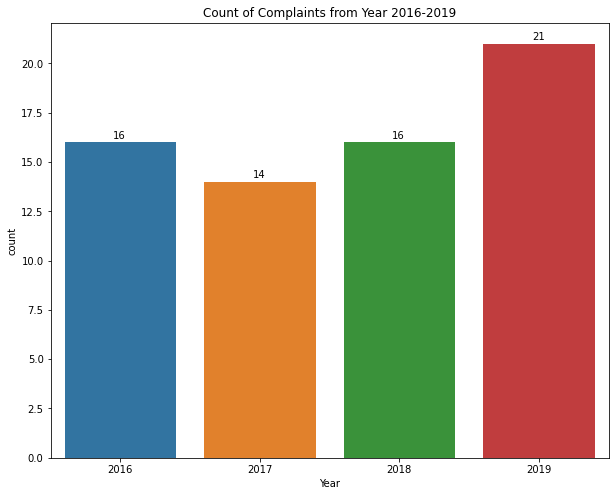

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Count of Complaints from Year 2016-2019')
ax = sns.countplot(x = complaints_san['Year'].sort_values())

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.2))

#### 5.2.2 Count by Month

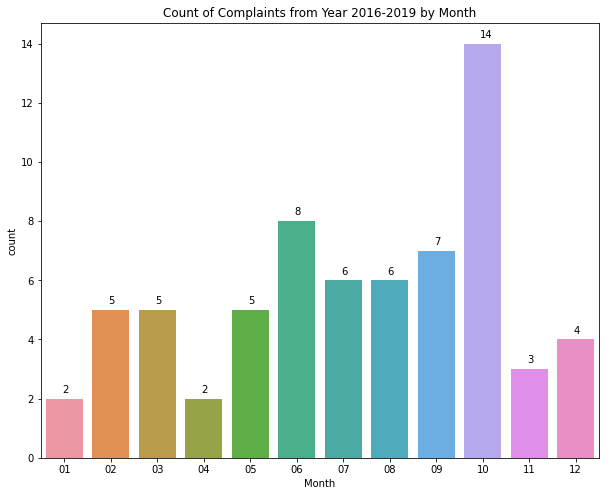

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Count of Complaints from Year 2016-2019 by Month')
ax = sns.countplot(x = complaints_san['Month'].sort_values())

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.2))

([<matplotlib.axis.YTick at 0x7f24195be0d0>,
 <a list of 5 Text major ticklabel objects>)

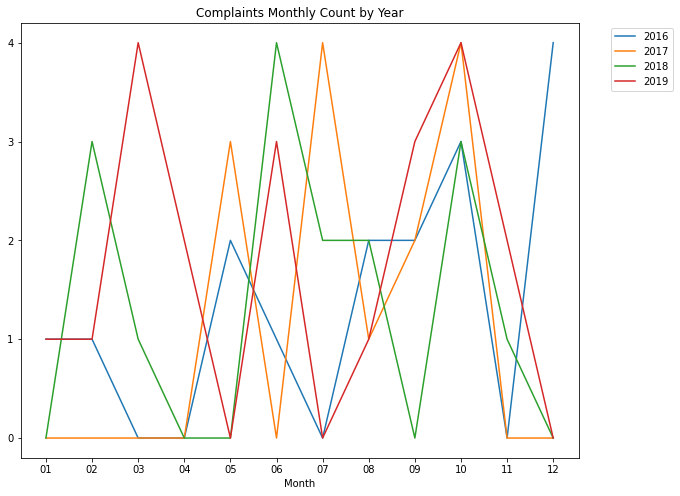

In [ ]:
complaints_month_year = pd.crosstab(complaints_san['Month'], complaints_san['Year'])

plt.figure(figsize=(10,8))
sns.lineplot(data = complaints_month_year, dashes=False).set(title = 'Complaints Monthly Count by Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yticks([0,1,2,3,4])

#### 5.2.3 Count by Weekday

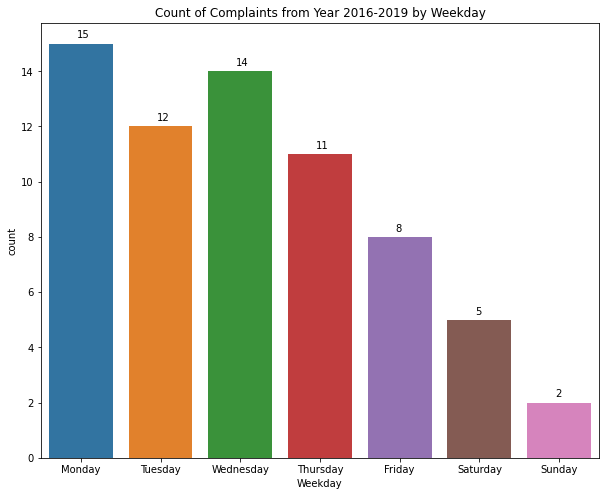

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Count of Complaints from Year 2016-2019 by Weekday')
ax = sns.countplot(x = complaints_san['Weekday']
                   , order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday'])

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.2))

([<matplotlib.axis.YTick at 0x7fe17fbba050>,
 <a list of 7 Text major ticklabel objects>)

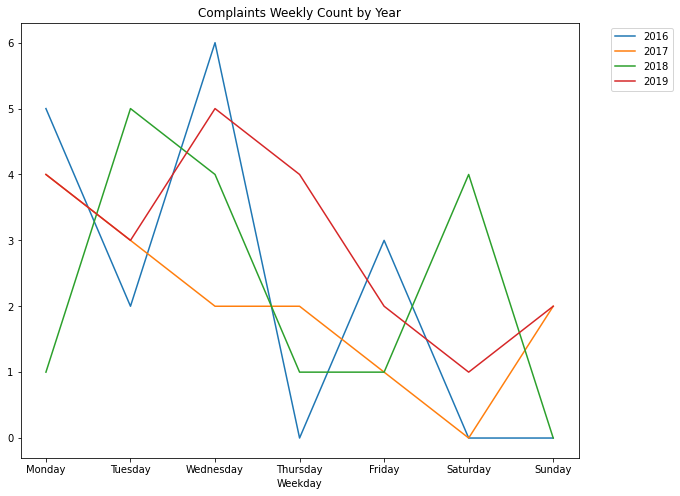

In [ ]:
# create the cross tab
complaints_day_year = pd.crosstab(complaints_san['Weekday'], complaints_san['Year'])
# reset index in the day order (plot order)
complaints_day_year = complaints_day_year.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday'])

plt.figure(figsize=(10,8))
sns.lineplot(data = complaints_day_year, dashes=False).set(title = 'Complaints Weekly Count by Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yticks([0,1,2,3,4,5,6])

### 5.3 Negative Generate

Because the complaints will be recored only when there exist complaints. Therefore we will randomly pick the same amount of locations and date where there is no complaints records to prepare for prediction.

In [ ]:
# add an extra column to identity the complaints
complaints_all = complaints_san[['Data', 'geometry', 'Year', 'Month', 'Weekday']].copy()
complaints_all.Data = complaints_all.Data.dt.date
complaints_all['complaints'] = 1

In [ ]:
# calculate the original time span based on the max and min date of complaints
# 1. find max and min 
start_date = complaints_all.Data.min()
end_date = complaints_all.Data.max()
# 2. calculate difference
diff = end_date - start_date
diff = diff.days

In [ ]:
# set column names
col_name = complaints_all.columns.to_list()

In [ ]:
import random

In [ ]:
# create an extra negative example for all rows in the dataset
for index,row in complaints_san.iterrows():

  random.seed(1000)

  i = 0
  while (i < 1):
    # randomly pick date
    random_number_of_days = random.randrange(diff)
    random_date = start_date + datetime.timedelta(days=random_number_of_days)
    complaints_0 = 0

    # get value for current row
    geometry = row['geometry']

    # check if exist such record
    exist = complaints_all[(complaints_all['Data'] == random_date) & \
                           (complaints_all['geometry'] == geometry)]
    if exist.empty:
      i += 1
      new_row = pd.DataFrame([[random_date, geometry, random_date.strftime('%Y')
                              ,random_date.strftime('%m'), random_date.strftime('%A')\
                               , complaints_0]], columns = col_name)
      complaints_all = complaints_all.append(new_row, ignore_index=True)
    else:
      print('There was a compliant at this place on sameday already.')

In [ ]:
complaints_all.shape

(134, 6)

Based on the previous 67 records of complaints, we now obtain a dataframe with 134 record that containts the date and location where half of the dataframe are complaints records and half are non-complaint records. We are now able to build model and make prediction based on this new dataframe.

### 5.4 Looking for the closet sensor

Given the coordinates of where the complaints are and sensors, in order to find the relationship between noise and complaints, what we want to do are:

+ find the closest sensor which noise record is available
+ find the mean and standard deviation of the noise information of that closest sensor on the date where the complaint was
+ find the distance of the closest sensor

In [ ]:
# get sensor location information
!wget https://wdl-data.fra1.digitaloceanspaces.com/torino/noise_sensor_GIS.zip
!unzip noise_sensor_GIS.zip

In [ ]:
# format the name of sensor the same as our dataframe
sensor_loc = gpd.read_file('/content/noise_sensor_GIS/Rilievi openoise.shp')
sensor_loc['name'] = ['C5','C4','C3','C2','C1']

In [ ]:
# calculate the distance between sensors and complaints
complaints_all['C1'] = complaints_all['geometry'].distance(sensor_loc['geometry'][4])
complaints_all['C2'] = complaints_all['geometry'].distance(sensor_loc['geometry'][3])
complaints_all['C3'] = complaints_all['geometry'].distance(sensor_loc['geometry'][2])
complaints_all['C4'] = complaints_all['geometry'].distance(sensor_loc['geometry'][1])
complaints_all['C5'] = complaints_all['geometry'].distance(sensor_loc['geometry'][0])

In [ ]:
# change the noise to numeric number
noise_full['C2'] = pd.to_numeric(noise_full['C2'])
noise_full['C3'] = pd.to_numeric(noise_full['C3'])
noise_full['C4'] = pd.to_numeric(noise_full['C4'])

# format the datetime 64 into date
noise_full['date'] = noise_full['italian_time'].dt.date

#### 5.4.1 Find closest sensor which noise records were available on that day

We here design the function to get the mean and standard deviation of the noise detected from the closest sensor based on the complaints date.

When there is no noise record for the closest, it will return the 2nd closest. When 2nd closest if also missing, it will return the 3rd closest. All the way looping to furthest sensor until it find a closest sensor with records.

In [ ]:
# set up what we are looking for
complaints_all['mean_noise'] = np.nan
complaints_all['std_noise'] = np.nan
complaints_all['closest_sensor'] = np.nan

for i in range(5):

  # filter the compliants cannot find the noise the i-1 th closest sensor
  complaints_all_missing = complaints_all[complaints_all.mean_noise.isna()]
  # find the ith closest sensor
  complaints_all_missing['closest_sensor'] = complaints_all_missing.apply(lambda x: ['C1','C2','C3','C4','C5'][x[['C1','C2','C3','C4','C5']].argsort()[i]], axis = 1)

  # calculate the mean noise of the closet sensor on the date when the complaints are 
  complaints_all_missing['mean_noise'] = complaints_all_missing.apply(lambda x: noise_full[noise_full['date'] == x['Data']][x['closest_sensor']].mean(), axis = 1)
  # calculate the std noise of the closet sensor on the date when the complaints are 
  complaints_all_missing['std_noise'] = complaints_all_missing.apply(lambda x: noise_full[noise_full['date'] == x['Data']][x['closest_sensor']].std(), axis = 1)

  # replace the data with index
  complaints_all.iloc[complaints_all_missing.index, :] = complaints_all_missing

  i += 1

In [ ]:
# 10 records can not find the noise average and standard deviation due to the missing records of all sensors that day
print('Missing noise mean and standard deviation for', complaints_all.mean_noise.isna().sum(),'records')

Missing noise mean and standard deviation for 10 records


We could the see the reason that we still cannot find noise records for those 10 complaints even if looking for all the sensor is that the happened before the earlist records for the sensors.

Therefore, we have to drop those complaints to ensure the accuracy. And we now have 124 pieces of complaints.

In [ ]:
print('Earliest noise records for sensors', noise_full.date.min())
print('Lastest date for compliants that cannot find noise information of sensor', complaints_all[complaints_all.mean_noise.isna()]['Data'].max())

Earliest noise records for sensors 2016-06-01
Lastest date for compliants that cannot find noise information of sensor 2016-05-30


In [ ]:
# drop the rows that cannot find noise records
complaints_all = complaints_all[complaints_all['mean_noise'].notna()]
complaints_all.shape

(124, 14)

#### 5.4.2 Calculate the distance of that closest sensor (noise record available)

In [ ]:
# reformat the dataframe
complaints_all.index = range(complaints_all.shape[0])
complaints_all['closest_sensor'] = complaints_all['closest_sensor'].astype(str)

In [ ]:
# find the closest sensor distance
complaints_all['sensor_dist'] = complaints_all.apply(lambda x: x[x['closest_sensor']], axis = 1)

In [ ]:
# select needed columns
complaints_all = complaints_all[['Data', 'geometry', 'Year', 'Month', 'Weekday', 'complaints'
                                , 'closest_sensor', 'mean_noise', 'std_noise','sensor_dist']]

### 5.5 Merge with the mean weather on that day

Considering the weather might affect the complaints, we would like to add the average value of weather that day to evaluate the model.

Since we do not have the accurate hours and time for the all the complaints, we then choose to use the average directly. If in the real application, we can input the real-time weather prediction.

In [ ]:
# merge the average weather information that day
complaints_all['Wind_gust'] = complaints_all.apply(lambda x: noise_full[noise_full['date'] == x['Data']]['Wind speed (gust m/s) '].mean(), axis = 1)
complaints_all['Wind_scalar'] = complaints_all.apply(lambda x: noise_full[noise_full['date'] == x['Data']]['Wind speed (scalar m/s) '].mean(), axis = 1)
complaints_all['Temp'] = complaints_all.apply(lambda x: noise_full[noise_full['date'] == x['Data']]['Temperature'].mean(), axis = 1)
complaints_all['Snow_depth'] = complaints_all.apply(lambda x: noise_full[noise_full['date'] == x['Data']]['Snow depth'].mean(), axis = 1)
complaints_all['Rain_level'] = complaints_all.apply(lambda x: noise_full[noise_full['date'] == x['Data']]['Rain level(Millimeters)'].mean(), axis = 1)

In [ ]:
complaints_all.head()

,Data,geometry,Year,Month,Weekday,complaints,closest_sensor,mean_noise,std_noise,sensor_dist,Wind_gust,Wind_scalar,Temp,Snow_depth,Rain_level
0,2016-08-10,POINT (7.68454 45.05980),2016,08,Wednesday,1,C2,60.695833,7.370769,0.003573,2.391667,0.782639,22.070833,-0.009167,0.022222
1,2016-12-27,POINT (7.68454 45.05980),2016,12,Tuesday,1,C2,57.616667,4.129709,0.003573,1.491667,0.462500,6.443750,0.009375,0.000000
2,2016-10-10,POINT (7.67715 45.05730),2016,10,Monday,1,C3,53.250000,5.211153,0.002087,1.679167,0.499306,10.583333,-0.014167,0.000000
3,2016-10-12,POINT (7.68043 45.05605),2016,10,Wednesday,1,C4,58.979167,4.624977,0.001794,1.391667,0.460417,9.779167,-0.013542,0.000000
4,2016-09-19,POINT (7.68043 45.05605),2016,09,Monday,1,C4,59.620833,4.897469,0.001794,1.366667,0.469444,18.512500,0.003958,0.000000


### 5.6 Model for Complaints Prediction

Since we would like to predict the whether there will be complaints that day at some place, we would then build a classification model.

#### 5.6.1 Preparation

At the preparation, we need to
+ split predictor and response
+ standardize the numeric
+ change the categorical variable to dummy variables
+ split train and test

In [ ]:
# split X and y
X = complaints_all.iloc[:,np.r_[2:5,6:15]]
y = complaints_all.complaints

In [ ]:
# standardize the numeric variables
from sklearn.preprocessing import StandardScaler

X[['mean_noise', 'std_noise','sensor_dist', 'Wind_gust', 'Wind_scalar', 'Temp'
  , 'Snow_depth','Rain_level']] = StandardScaler().fit_transform(X[['mean_noise', 'std_noise','sensor_dist'
                                                                    , 'Wind_gust', 'Wind_scalar', 'Temp'
                                                                    , 'Snow_depth','Rain_level']])

In [ ]:
# we have 4 categorical variables that need to be changed to dummy
# change all the categorical variable into category
for col in ['Year', 'Month', 'Weekday', 'closest_sensor']:
    X[col] = X[col].astype('category')

In [ ]:
# define dummy function to create dummy variables for each categorical variable
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

In [ ]:
# apply dummy function on categorical variables
X = create_dummies(X, 'Year')
X = create_dummies(X, 'Month')
X = create_dummies(X, 'Weekday')
X = create_dummies(X, 'closest_sensor')

In [ ]:
# present the list of what need to be put inside the model
X.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   mean_noise         124 non-null    float64
 1   std_noise          124 non-null    float64
 2   sensor_dist        124 non-null    float64
 3   Wind_gust          124 non-null    float64
 4   Wind_scalar        124 non-null    float64
 5   Temp               124 non-null    float64
 6   Snow_depth         124 non-null    float64
 7   Rain_level         124 non-null    float64
 8   Year_2017          124 non-null    uint8  
 9   Year_2018          124 non-null    uint8  
 10  Year_2019          124 non-null    uint8  
 11  Month_02           124 non-null    uint8  
 12  Month_03           124 non-null    uint8  
 13  Month_04           124 non-null    uint8  
 14  Month_05           124 non-null    uint8  
 15  Month_06           124 non-null    uint8  
 16  Month_07          

In [ ]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

Define the function needed for predition.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# import the metrics class
from sklearn import metrics

# define confusion matix plot function
def confusion_matrix_plot(y_pred):
  pred_matrix = metrics.confusion_matrix(y_test, y_pred)

  class_names=[0,1] # name  of classes
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  # create heatmap

  sns.heatmap(pd.DataFrame(pred_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

In [ ]:
# accuracy, precision, recall and f1 will be chosen to evaluate model
result_col = ['model','accuracy','precision','recall','F1-score','AUC']

# create a result dataframe for model comparson
result = []

In [ ]:
# create function for save and print other model evalution 
def model_result(y_pred ,auc, name,result):

  # get result
  acc = metrics.accuracy_score(y_test, y_pred)
  prec = metrics.precision_score(y_test, y_pred)
  rec = metrics.recall_score(y_test, y_pred)
  f1 = metrics.f1_score(y_test, y_pred)

  # print result
  print(name, "Accuracy:",acc)
  print(name,"Precision:",prec)
  print(name,"Recall:",rec)
  print(name,'F1-score',f1)

  #save into result dataframe
  new_row = [name,acc , prec, rec, f1,auc]
  result = result.append(new_row)

#### 5.6.2 Random Forest

##### 5.6.2.1 Use Default Hyperparametets

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
rf=RandomForestClassifier(random_state=100)

#Train the model using the training sets
rf.fit(X_train,y_train)

# prediction
y_pred_rf = rf.predict(X_test)

In [ ]:
from pprint import pprint

# get paramters from the default random forest
pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 100,
 'verbose': 0,
 'warm_start': False}


No handles with labels found to put in legend.


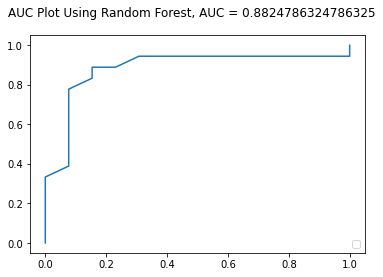

In [ ]:
y_pred_proba_rf = rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_rf)
auc_rf = metrics.roc_auc_score(y_test, y_pred_proba_rf)

fig = plt.figure()
fig.suptitle('AUC Plot Using Random Forest, AUC = ' + str(auc_rf))
plt.plot(fpr,tpr)
plt.legend(loc=4)
plt.show()

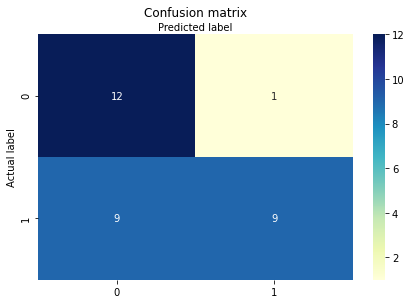

In [ ]:
# confusion matrix
confusion_matrix_plot(y_pred_rf)

In [ ]:
# model evaluation
model_result(y_pred_rf,auc_rf,'Random Forest with Default',result)

Random Forest with Default Accuracy: 0.6774193548387096
Random Forest with Default Precision: 0.9
Random Forest with Default Recall: 0.5
Random Forest with Default F1-score 0.6428571428571429


##### 5.6.2.2 Tune Hyperparameters

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest - default using 100
n_estimators = [10, 30, 50, 70, 100, 200, 500,1000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [3,5,7,9]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True],
 'max_depth': [3, 5, 7, 9, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 30, 50, 70, 100, 200, 500, 1000]}


In [ ]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
rf_set = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf_set, param_distributions = random_grid, \
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
# best tuning paremeters result
rf_random.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# fit the random forest with best esitmator
rf_tune = rf_random.best_estimator_
rf_tune.fit(X_train,y_train)

# prediction with best estimator
y_pred_rf_tune = rf_tune.predict(X_test)

No handles with labels found to put in legend.


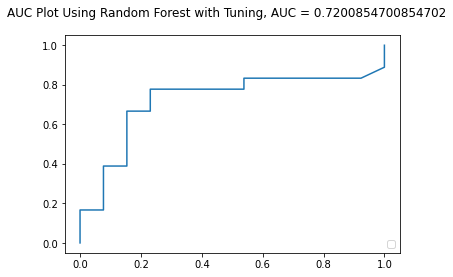

In [ ]:
# ROC - AUC curve
y_pred_proba_tune = rf_tune.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_tune)
auc_rf_tune = metrics.roc_auc_score(y_test, y_pred_proba_tune)

fig = plt.figure()
fig.suptitle('AUC Plot Using Random Forest with Tuning, AUC = ' + str(auc_rf_tune))
plt.plot(fpr,tpr)
plt.legend(loc=4)
plt.show()

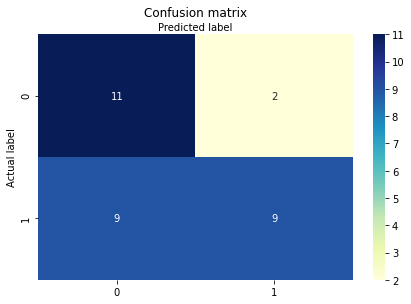

In [ ]:
# confusion matrix
confusion_matrix_plot(y_pred_rf_tune)

In [ ]:
# model evaluation
model_result(y_pred_rf_tune,auc_rf_tune,'Random Forest with Tuning',result)

Random Forest with Tuning Accuracy: 0.6451612903225806
Random Forest with Tuning Precision: 0.8181818181818182
Random Forest with Tuning Recall: 0.5
Random Forest with Tuning F1-score 0.6206896551724137


#### 5.6.3 XGBoost

##### 5.6.3.1 Using Default

In [ ]:
# import XGB model for classification
from xgboost import XGBClassifier

# create a model
xgb = XGBClassifier(seed = 1000)

# fit 
xgb.fit(X_train, y_train)

# predict
y_pred_xgb = xgb.predict(X_test)

No handles with labels found to put in legend.


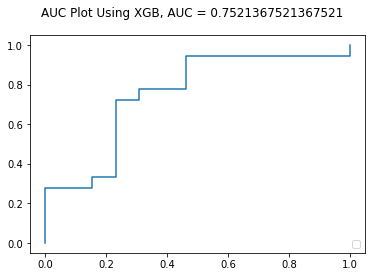

In [ ]:
# ROC - AUC curve
y_pred_proba_xgb = xgb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_xgb)
auc_xgb = metrics.roc_auc_score(y_test, y_pred_proba_xgb)

fig = plt.figure()
fig.suptitle('AUC Plot Using XGB, AUC = ' + str(auc_xgb))
plt.plot(fpr,tpr)
plt.legend(loc=4)
plt.show()

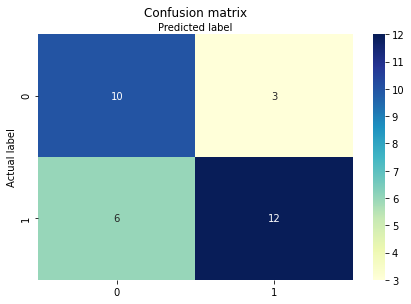

In [ ]:
# confustion matrix for prediction based on XGB
confusion_matrix_plot(y_pred_xgb)

In [ ]:
# model result evalution
model_result(y_pred_xgb,auc_xgb, 'XGBoosting with Default',result)

XGBoosting with Default Accuracy: 0.7096774193548387
XGBoosting with Default Precision: 0.8
XGBoosting with Default Recall: 0.6666666666666666
XGBoosting with Default F1-score 0.7272727272727272


##### 5.6.3.2 Tune

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# learning_rate - default = 0.1
learning_rate = [0.01,0.05,0.1,0.2]
# columns randomly selected at each tree - default  = 1
colsample_bytree = [0.5, 0.75, 1]
# sample selected for prediction at each split
subsample = [0.5, 0.75 , 1]

# Create the random grid
xgb_grid = {'learning_rate': learning_rate,
               'colsample_bytree': colsample_bytree,
               'subsample': subsample}

In [ ]:
# Use the grid to search for best hyperparameters

# define classifier
xgb_set = XGBClassifier(seed = 1000)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb_set, param_distributions = xgb_grid, \
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
xgb_random.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    2.3s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=1000, silent=None, subsample=1,
                                           verbosity=1),
                   iid='de

In [ ]:
# result for the best estimator
xgb_random.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1000,
              silent=None, subsample=0.75, verbosity=1)

In [ ]:
# fit the xgb with best esitmator
xgb_tune = xgb_random.best_estimator_
xgb_tune.fit(X_train,y_train)

# prediction with best estimator
y_pred_xgb_tune = xgb_tune.predict(X_test)

No handles with labels found to put in legend.


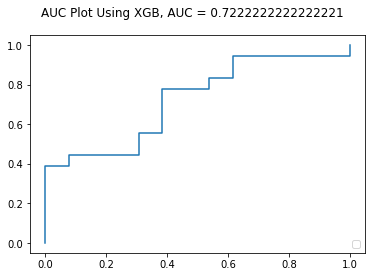

In [ ]:
# ROC - AUC curve
y_pred_proba_xgb_tune = xgb_tune.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_xgb_tune)
auc_xgb_tune = metrics.roc_auc_score(y_test, y_pred_proba_xgb_tune)

fig = plt.figure()
fig.suptitle('AUC Plot Using XGB, AUC = ' + str(auc_xgb_tune))
plt.plot(fpr,tpr)
plt.legend(loc=4)
plt.show()

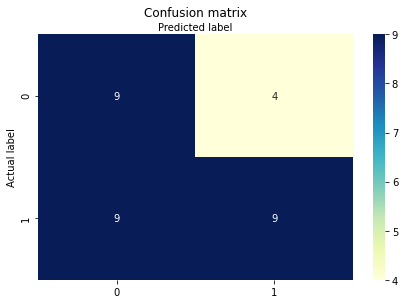

In [ ]:
# confusion matrix
confusion_matrix_plot(y_pred_xgb_tune)

In [ ]:
# model evaluation
model_result(y_pred_xgb_tune,auc_xgb_tune,'XGBoosting after Tuning',result)

XGBoosting after Tuning Accuracy: 0.5806451612903226
XGBoosting after Tuning Precision: 0.6923076923076923
XGBoosting after Tuning Recall: 0.5
XGBoosting after Tuning F1-score 0.5806451612903226


#### 5.7 Model Comparsion

In [ ]:
# result for each model in the previous section
result_df = pd.DataFrame(result, columns=result_col)
result_df = result_df.set_index('model')
result_df = result_df.iloc[:, [0,1,4]]

[Text(0.5, 1.0, 'Complaints Model Comparison')]

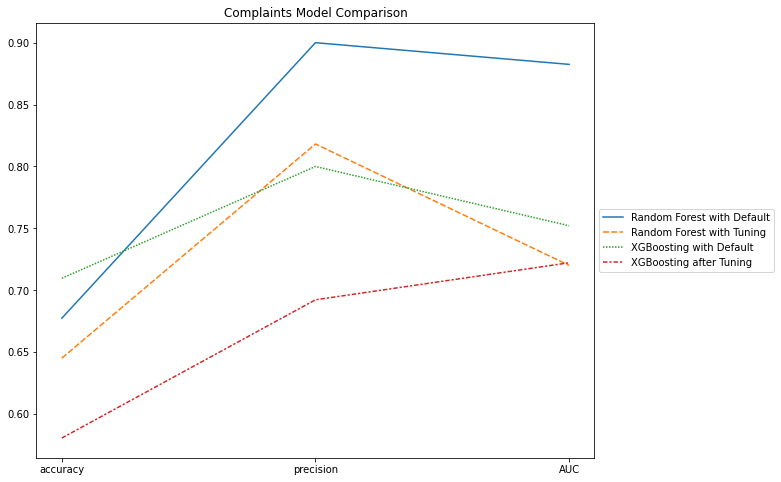

In [ ]:
fig = plt.subplots(figsize=(10,8))
p = sns.lineplot(data = result_df.T)
p.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
p.set(title = 'Complaints Model Comparison')

Based on the previous plot, we decide to pick the Random Forest with Default. Although the accuracy of that model is not the best, Random forest with default outperforms the the rest models severely on precision and AUC.

No handles with labels found to put in legend.


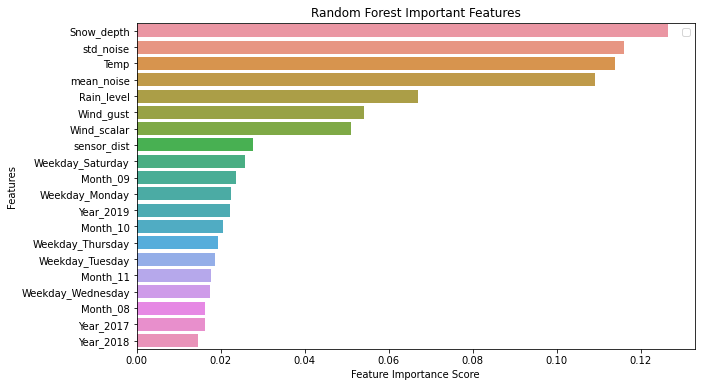

In [ ]:
# feature importance for random forest
feature_imp = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot for feature importance top 20
plt.subplots(figsize=(10, 6))
sns.barplot(x=feature_imp[:20], y=feature_imp.index[:20])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Random Forest Important Features")
plt.legend()
plt.show()

References

NYC Noise Control Guidance: https://www1.nyc.gov/assets/dep/downloads/pdf/air/noise/noise-control-nightclubs-restaurants-bars-cafes-product-services-guidance-sheet.pdf

Acoustic reflection: https://www.sonic-shield.com/sonic-shields-soundproofing-blog/noisy-nightclubs-acoustic-solutions

